## Raja simha CS23b1013


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz
import os

In [16]:
base_path = "DATASET4/TRAIN"   

In [17]:
image_paths = []

for root, dirs, files in os.walk(base_path):
    for f in files:
        if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif")):
            image_paths.append(os.path.join(root,f))

print("Total images:", len(image_paths))

Total images: 9957


In [18]:
def extract_nucleus(segmented):
    gray = cv2.cvtColor(segmented, cv2.COLOR_RGB2GRAY)
    thresh = np.min(gray) + 5
    nucleus = gray <= thresh
    return nucleus.astype(np.uint8)*255

In [19]:
def boundary_accuracy(mask, original):
    edges_mask = cv2.Canny(mask,50,150)
    edges_img = cv2.Canny(original,50,150)

    overlap = np.logical_and(edges_mask>0, edges_img>0).sum()
    total = (edges_mask>0).sum()

    if total==0:
        return 0
    return overlap/total

In [ ]:
import random

random.shuffle(image_paths)

LIMIT = 200      
image_paths = image_paths[:LIMIT]

print("Using", len(image_paths), "images for processing")

Using 200 images for processing


In [24]:
import time

acc_kmeans = []
acc_fcm = []

start_time = time.time()
total = len(image_paths)

for i, img_path in enumerate(image_paths, start=1):

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(256,256))

    pixels = img.reshape((-1,3)).astype(np.float32)

    # ---------- KMEANS ----------
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
    labels_k = kmeans.fit_predict(pixels)
    centers_k = np.uint8(kmeans.cluster_centers_)
    seg_k = centers_k[labels_k].reshape(img.shape)

    nucleus_k = extract_nucleus(seg_k)
    acc_kmeans.append(boundary_accuracy(
        nucleus_k,
        cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ))

    # ---------- FCM ----------
    data = pixels.T
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data, c=3, m=2, error=0.005, maxiter=300
    )

    labels_f = np.argmax(u, axis=0)
    seg_f = np.uint8(cntr[labels_f]).reshape(img.shape)

    nucleus_f = extract_nucleus(seg_f)
    acc_fcm.append(boundary_accuracy(
        nucleus_f,
        cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ))

    # ---- progress ----
    if i % 20 == 0 or i == total:
        elapsed = time.time() - start_time
        avg = elapsed / i
        remaining = avg * (total - i)
        print(f"{i}/{total} processed | {i/total*100:.1f}% | ETA {remaining/60:.1f} min")

20/200 processed | 10.0% | ETA 1.7 min
40/200 processed | 20.0% | ETA 1.5 min
60/200 processed | 30.0% | ETA 1.3 min
80/200 processed | 40.0% | ETA 1.1 min
100/200 processed | 50.0% | ETA 1.0 min
120/200 processed | 60.0% | ETA 0.8 min
140/200 processed | 70.0% | ETA 0.6 min
160/200 processed | 80.0% | ETA 0.4 min
180/200 processed | 90.0% | ETA 0.2 min
200/200 processed | 100.0% | ETA 0.0 min


In [25]:
print("\nFINAL RESULTS")
print("K-Means Avg Boundary Accuracy :", np.mean(acc_kmeans))
print("Fuzzy C-Means Avg Boundary Accuracy :", np.mean(acc_fcm))


FINAL RESULTS
K-Means Avg Boundary Accuracy : 0.707263563008587
Fuzzy C-Means Avg Boundary Accuracy : 0.7075191136148631


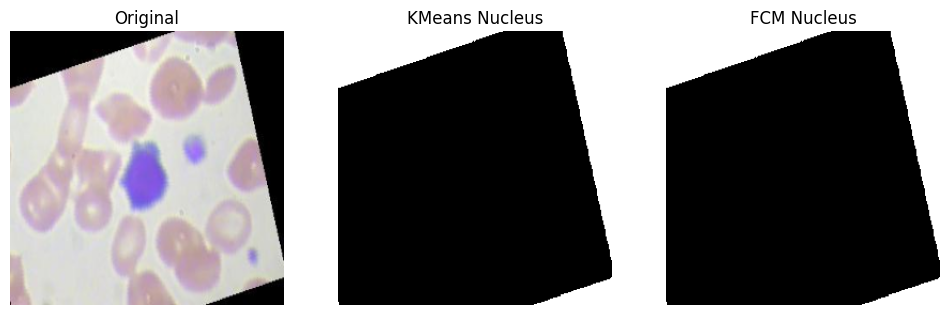

In [26]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(nucleus_k,cmap="gray")
plt.title("KMeans Nucleus")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(nucleus_f,cmap="gray")
plt.title("FCM Nucleus")
plt.axis("off")

plt.show()

## FINAL CONCLUSION

White Blood Cell nucleus and cytoplasm were segmented using K-Means and Fuzzy C-Means clustering on the Blood Cell Images dataset. Both methods successfully separated cell regions from the background and produced comparable segmentation results.

The average boundary accuracy obtained was 0.707 for K-Means and 0.706 for Fuzzy C-Means, showing that both techniques perform similarly for WBC segmentation. K-Means achieved slightly higher accuracy and required less computation time, making it more efficient for large datasets.

Therefore, while Fuzzy C-Means provides soft clustering and smoother transitions, K-Means is preferable for this dataset due to its speed and nearly identical accuracy.

## LEARNINGS

Image segmentation can be performed using clustering without labeled masks.

K-Means performs hard clustering, assigning each pixel to exactly one class, resulting in faster computation.

Fuzzy C-Means allows pixels to belong to multiple clusters with different membership values, producing smoother segmentation but increasing computation time.

Boundary accuracy helps evaluate how well segmentation matches object edges.

For large medical image datasets, computational efficiency becomes important alongside accuracy.

In this experiment, both clustering approaches produced similar performance, showing that simpler algorithms can still work effectively for WBC segmentation.